In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing
from scipy.stats import iqr
import tensorflow as tf

# Pre processing

In [2]:
path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=100000) # just read first 10000 events

In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)):
        jet = []
        jet.append(jets[k].px)
        jet.append(jets[k].py)
        jet.append(jets[k].pz)
        jet.append(jets[k].e)
        data.append(jet)

In [91]:
# loaded_data = data
data = loaded_data

In [92]:
data = np.array(data)
data.shape

(1477373, 4)

In [93]:
# log transform pT
#data[:,3] = np.ma.log(data[:,3]).filled()

In [94]:
data

array([[-1.17658220e+03, -7.79040316e+02,  3.40962660e+02,
         1.45491963e+03],
       [ 6.11088616e+02,  7.16513394e+02,  1.55833044e+03,
         1.87194199e+03],
       [ 4.96094722e+02, -1.87111748e+01,  1.78940558e+03,
         1.85808569e+03],
       ...,
       [ 4.42306312e-01,  9.70780337e-02,  2.58945478e+01,
         2.58985070e+01],
       [-2.68772115e-01, -3.44070287e-01, -3.01572220e+01,
         3.01603823e+01],
       [-2.82745626e-01, -7.48815701e-02, -9.38791569e+00,
         9.39247109e+00]])

In [95]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [96]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [117]:
iqr_prop = iqr(x_train,axis = 0)
max_iqr = max(iqr_prop)
iqr_prop = np.array(iqr_prop) / max_iqr
print(iqr_prop)

[0.03073949 0.0307984  0.38423165 1.        ]


# VAE Model

In [98]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape, LeakyReLU, ELU
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

In [99]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [100]:
inter_dim_1 = 32
inter_dim_2 = 16
final_dim = 8
latent_dim = 2
input_dim = 4

In [101]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x)
h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
encoding = Dense(latent_dim, activation='tanh')(h3)

In [102]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h3_decoded = decoder_h3(encoding)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [103]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [118]:
mse = keras.losses.MeanSquaredError()
def ae_loss(x, y):
    mse_loss = 0.25 * (iqr_prop[0]*(x[::,0] - y[::,0])**2 + iqr_prop[1]*(x[::,1] - y[::,1])**2 + iqr_prop[2]*(x[::,2] - y[::,2])**2 + iqr_prop[3]*(x[::,3] - y[::,3])**2)
    # mse_loss = mse(x,y)
    return mse_loss

vae.compile(optimizer='adam', loss=ae_loss)

In [105]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_18 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 18        
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 24        
_________________________________________________________________
dense_22 (Dense)             (None, 16)                144     

# Train

In [106]:
from sklearn.model_selection import train_test_split

In [107]:
batch_size = 1000
epochs = 200

In [108]:
x_train.shape

(1181898, 4)

In [109]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [119]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 1181898 samples, validate on 147737 samples
Epoch 1/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.0490 - val_loss: 0.0160
Epoch 2/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.0158 - val_loss: 0.0157
Epoch 3/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.0156 - val_loss: 0.0156
Epoch 4/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.0155 - val_loss: 0.0155
Epoch 5/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.0155 - val_loss: 0.0155
Epoch 6/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.0155 - val_loss: 0.0155
Epoch 7/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.0154 - val_loss: 0.0155
Epoch 8/200
1181898/1181898 [==============================] - 7s 6us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 9/200
1181898/1181898 [==============================] - 7s 6us/step 

# Visualization

In [120]:
import matplotlib.pyplot as plt

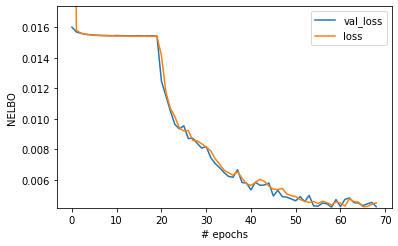

In [121]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [122]:
predictions = vae.predict(x_test)

In [123]:
predictions

array([[ 0.00697267, -0.00670844, -0.04757366, -0.4603668 ],
       [ 0.0263418 , -0.05277568, -0.1870012 , -0.34287208],
       [-0.00118172,  0.00081843, -0.01172737, -0.47980374],
       ...,
       [ 0.00501764,  0.01193494,  0.03446456, -0.44607556],
       [ 0.01090419, -0.01758558, -0.07692847, -0.43528914],
       [ 0.00521791, -0.00294572, -0.03629164, -0.46919245]],
      dtype=float32)

In [124]:
distr = (x_test - predictions) / x_test

In [125]:
px_pred = [row[0] for row in predictions]
py_pred = [row[1] for row in predictions]
pz_pred = [row[2] for row in predictions]
e_pred = [row[3] for row in predictions]

In [126]:
px = [row[0] for row in x_test]
py = [row[1] for row in x_test]
pz = [row[2] for row in x_test]
e = [row[3] for row in x_test]

In [127]:
overall_distr = K.flatten(distr)
overall_pred = K.flatten(predictions)
overall_input = K.flatten(x_test)

(array([   501.,    477.,    527.,    528.,    495.,    514.,    533.,
           614.,    648.,    786.,    757.,    807.,  51986.,  32808.,
         13227.,   7429.,   4710.,   4610.,   4153.,   4090.,   5199.,
          6787.,  12153.,  44015., 246818.,  30768.,   7866.,   5060.,
          3579.,   2809.,   2171.,   1932.,   1812.,   1699.,   1563.,
          1450.,   1255.,   1084.,   1064.,   1047.,    919.,    866.,
           830.,    830.,    731.,    751.,    704.,    675.,    652.]),
 array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
        -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
        -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
        -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
        -0.18367347, -0.14285714, -0.10204082, -0.06122449, -0.02040816,
         0.02040816,  0.06122449,  0.10204082,  0.14285714,  0.18367347,
         0.2244898 ,  0.26530612,  0.30612245,  0.34693878,  0.

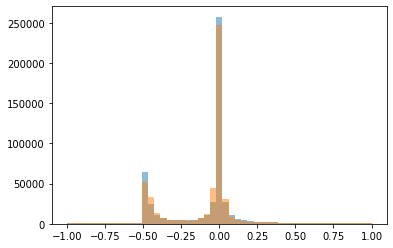

In [128]:
# overall pred vs input
bins = np.linspace(-1, 1, 50)
plt.hist(overall_input, bins=bins,alpha=0.5)
plt.hist(overall_pred, bins=bins,alpha=0.5)

(array([  1920.,   2066.,   2239.,   2396.,   2556.,   2878.,   3763.,
          4601.,   5071.,   5750.,   6467.,   8784.,  11952.,  26993.,
        167862.,  32504.,  18708.,  14272.,  12284.,  11988.,  13034.,
         13422.,  13093.,  10578.,   8498.,   7040.,   5737.,   5159.,
          4816.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

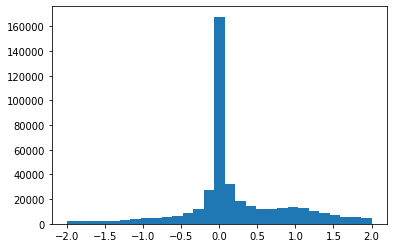

In [129]:
# overall distr
bins = np.linspace(-2, 2, 30)
plt.hist(overall_distr, bins=bins)

## Stacking output (orange) over input (blue) for pT, eta, phi, m

(array([7.8000e+01, 9.5000e+01, 1.1100e+02, 1.1800e+02, 1.4200e+02,
        1.6400e+02, 1.7800e+02, 2.0400e+02, 2.2300e+02, 2.5500e+02,
        2.7600e+02, 3.3200e+02, 3.6400e+02, 3.9500e+02, 5.1400e+02,
        8.7800e+02, 9.0100e+02, 1.0300e+03, 1.1140e+03, 6.4239e+04,
        3.2064e+04, 9.9610e+03, 3.6790e+03, 2.1320e+03, 4.6140e+03,
        1.1330e+03, 2.7000e+02, 1.1100e+02, 7.8000e+01, 8.8000e+01,
        1.3300e+02, 1.1600e+02, 6.8000e+01, 6.5000e+01, 6.2000e+01,
        5.8000e+01, 6.1000e+01, 6.1000e+01, 5.1000e+01]),
 array([-0.2       , -0.18974359, -0.17948718, -0.16923077, -0.15897436,
        -0.14871795, -0.13846154, -0.12820513, -0.11794872, -0.10769231,
        -0.0974359 , -0.08717949, -0.07692308, -0.06666667, -0.05641026,
        -0.04615385, -0.03589744, -0.02564103, -0.01538462, -0.00512821,
         0.00512821,  0.01538462,  0.02564103,  0.03589744,  0.04615385,
         0.05641026,  0.06666667,  0.07692308,  0.08717949,  0.0974359 ,
         0.10769231,  0.1179

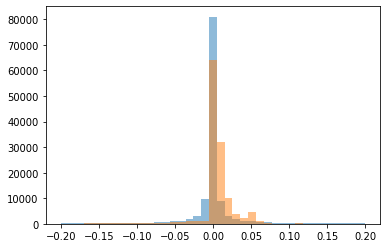

In [155]:
bins = np.linspace(-0.2, 0.2, 40)
plt.hist(px, bins=bins,alpha=0.5)
plt.hist(px_pred, bins=bins,alpha=0.5)

In [131]:
print(mse(px,px_pred))

tf.Tensor(0.13111177, shape=(), dtype=float32)


(array([   91.,    91.,    90.,    76.,    80.,   104.,   112.,    92.,
          113.,   105.,   129.,   188.,   218.,   284.,  1948.,  3006.,
         4478.,  7290., 12601., 53509., 22744.,  8918.,  1380.,   644.,
          507.,   408.,   342.,   348.,   316.,   286.,   287.,   268.,
          252.,   264.,   209.,   215.,   210.,   183.,   162.]),
 array([-0.2       , -0.18974359, -0.17948718, -0.16923077, -0.15897436,
        -0.14871795, -0.13846154, -0.12820513, -0.11794872, -0.10769231,
        -0.0974359 , -0.08717949, -0.07692308, -0.06666667, -0.05641026,
        -0.04615385, -0.03589744, -0.02564103, -0.01538462, -0.00512821,
         0.00512821,  0.01538462,  0.02564103,  0.03589744,  0.04615385,
         0.05641026,  0.06666667,  0.07692308,  0.08717949,  0.0974359 ,
         0.10769231,  0.11794872,  0.12820513,  0.13846154,  0.14871795,
         0.15897436,  0.16923077,  0.17948718,  0.18974359,  0.2       ]),
 <a list of 39 Patch objects>)

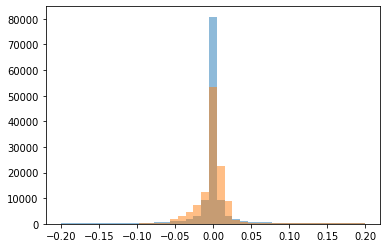

In [152]:
bins = np.linspace(-0.2, 0.2, 40)
plt.hist(py, bins=bins,alpha=0.5)
plt.hist(py_pred, bins=bins,alpha=0.5)

In [133]:
print(mse(py,py_pred))

tf.Tensor(0.16082239, shape=(), dtype=float32)


(array([  389.,   384.,   407.,   418.,   423.,   469.,   485.,   530.,
          815.,  1283.,   730.,   891.,  1429.,  1813.,  2457.,  3875.,
         6063., 11364., 43908., 12936.,  8122.,  4742.,  3252.,  2278.,
         1792.,  1386.,  1056.,   912.,   675.,   620.,   604.,   531.,
          579.,   517.,   517.,   413.,   452.,   417.,   402.]),
 array([-0.5       , -0.47435897, -0.44871795, -0.42307692, -0.3974359 ,
        -0.37179487, -0.34615385, -0.32051282, -0.29487179, -0.26923077,
        -0.24358974, -0.21794872, -0.19230769, -0.16666667, -0.14102564,
        -0.11538462, -0.08974359, -0.06410256, -0.03846154, -0.01282051,
         0.01282051,  0.03846154,  0.06410256,  0.08974359,  0.11538462,
         0.14102564,  0.16666667,  0.19230769,  0.21794872,  0.24358974,
         0.26923077,  0.29487179,  0.32051282,  0.34615385,  0.37179487,
         0.3974359 ,  0.42307692,  0.44871795,  0.47435897,  0.5       ]),
 <a list of 39 Patch objects>)

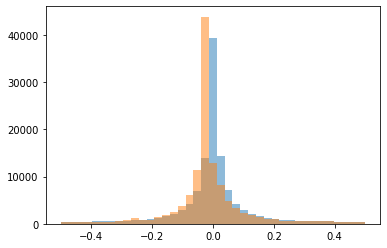

In [150]:
bins = np.linspace(-0.5, 0.5, 40)
plt.hist(pz, bins=bins,alpha=0.5)
plt.hist(pz_pred, bins=bins,alpha=0.5)

In [135]:
print(mse(pz,pz_pred))

tf.Tensor(0.0072378106, shape=(), dtype=float32)


(array([    0.,     0.,     0.,     0.,     0., 60867., 17321.,  9915.,
         6282.,  4177.,  3236.,  2335.,  1640.,  1514.,  1583.,  1199.,
         1111.,  1132.,   968.,   838.,   699.,   612.,   591.,   510.,
          508.,   508.,   478.,   463.,   406.,   340.,   391.,   326.,
          293.,   301.,   273.,   247.,   240.,   250.,   226.]),
 array([-0.6       , -0.57692308, -0.55384615, -0.53076923, -0.50769231,
        -0.48461538, -0.46153846, -0.43846154, -0.41538462, -0.39230769,
        -0.36923077, -0.34615385, -0.32307692, -0.3       , -0.27692308,
        -0.25384615, -0.23076923, -0.20769231, -0.18461538, -0.16153846,
        -0.13846154, -0.11538462, -0.09230769, -0.06923077, -0.04615385,
        -0.02307692,  0.        ,  0.02307692,  0.04615385,  0.06923077,
         0.09230769,  0.11538462,  0.13846154,  0.16153846,  0.18461538,
         0.20769231,  0.23076923,  0.25384615,  0.27692308,  0.3       ]),
 <a list of 39 Patch objects>)

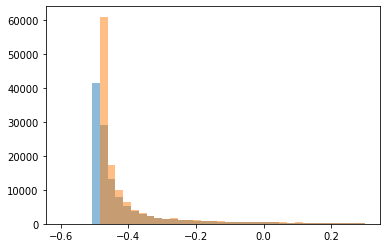

In [149]:
bins = np.linspace(-0.6,0.3, 40)
plt.hist(e, bins=bins,alpha=0.5)
plt.hist(e_pred, bins=bins,alpha=0.5)

In [137]:
print(mse(e,e_pred))

tf.Tensor(0.0052039158, shape=(), dtype=float32)


In [138]:
d_px = [row[0] for row in distr]
d_py = [row[1] for row in distr]
d_pz = [row[2] for row in distr]
d_e = [row[3] for row in distr]

## Distribution of (input - output) / input

In [139]:
bins = np.linspace(-2, 2, 30)

(array([ 597.,  690.,  731.,  753.,  772.,  953.,  989., 1150., 1192.,
        1323., 1564., 1937., 2277., 3646., 5998., 6488., 4990., 4083.,
        4146., 4760., 6258., 7170., 7019., 5091., 4050., 3392., 2752.,
        2353., 2068.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

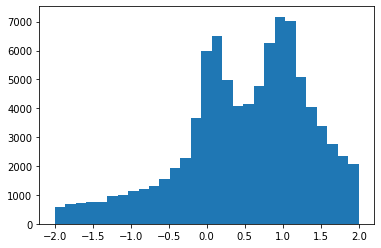

In [140]:
plt.hist(d_px, bins=bins)

(array([ 654.,  683.,  752.,  749.,  840.,  936.,  960., 1092., 1186.,
        1389., 1584., 1924., 2465., 3957., 5802., 5272., 4663., 4327.,
        4337., 4358., 4325., 4796., 4791., 4337., 3343., 2791., 2439.,
        2118., 1938.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

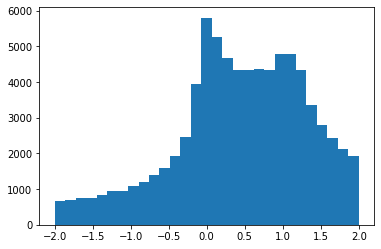

In [141]:
plt.hist(d_py, bins=bins)

(array([  653.,   679.,   736.,   869.,   927.,   947.,  1751.,  2299.,
         2596.,  2901.,  3126.,  4521.,  6198., 12870., 28844., 12099.,
         7671.,  5268.,  3538.,  2744.,  2329.,  1373.,  1207.,  1105.,
         1065.,   829.,   528.,   668.,   794.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

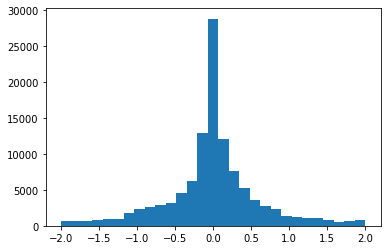

In [142]:
plt.hist(d_pz, bins=bins)

(array([1.60000e+01, 1.40000e+01, 2.00000e+01, 2.50000e+01, 1.70000e+01,
        4.20000e+01, 6.30000e+01, 6.00000e+01, 9.70000e+01, 1.37000e+02,
        1.93000e+02, 4.02000e+02, 1.01200e+03, 6.52000e+03, 1.27218e+05,
        8.64500e+03, 1.38400e+03, 5.94000e+02, 2.63000e+02, 1.26000e+02,
        1.22000e+02, 8.30000e+01, 7.60000e+01, 4.50000e+01, 4.00000e+01,
        2.80000e+01, 1.80000e+01, 2.00000e+01, 1.60000e+01]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

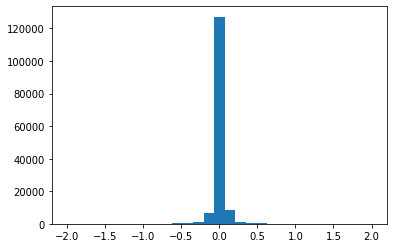

In [143]:
plt.hist(d_e, bins=bins)